## DataSet

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode



from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample

import cv2
from torch.utils.data import Dataset

In [ ]:
!gdown --id 1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
!gdown --id 1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl

Downloading...
From: https://drive.google.com/uc?id=1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
To: /content/2d_images.zip.zip
102MB [00:00, 111MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl
To: /content/2d_masks.zip.zip
100% 585k/585k [00:00<00:00, 35.7MB/s]


In [ ]:
%mkdir Dataset
%mkdir Dataset/2d_images
%mkdir Dataset/2d_masks

In [ ]:
!unzip -q 2d_images.zip.zip 
!unzip -q 2d_images.zip -d Dataset/2d_images

!unzip -q 2d_masks.zip.zip 
!unzip -q 2d_masks.zip -d Dataset/2d_masks

In [ ]:
!rm -rf 2d_images.zip.zip
!rm -rf 2d_images.zip

!rm -rf 2d_masks.zip.zip
!rm -rf 2d_masks.zip

## DataLoader

In [ ]:
class CT_Data(Dataset):

    def __init__(self, csv_file, root_dir):

        self.image_frame = pd.read_csv(csv_file, skiprows=1)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 0])
        mask_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 1])
        image = cv2.imread(img_name, 0)
        image = cv2.resize(image,(32, 32))
        image = image.reshape((1, 32, 32))
        mask = cv2.imread(mask_name, 0)
        mask = cv2.resize(mask, (32, 32))
        mask = mask.reshape((1, 32, 32))
        sample = {'image': image, 'mask': mask}
        return sample

In [ ]:
img_dir = "Dataset/2d_images/"
msk_dir = "Dataset/2d_masks/"
with open('Dataset/Dataset.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(img_dir):
        image_path = os.path.join(img_dir, p)
        mask_path = os.path.join(msk_dir, p)
        writer.writerow([image_path, mask_path])


data = pd.read_csv("Dataset/Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
partition = int(len(data)*0.7)
train, validation = data[:partition], data[partition:]
train.to_csv("Dataset/Train.csv", index=False)
validation.to_csv("Dataset/Validation.csv", index=False)

train_dataset = CT_Data(csv_file='Dataset/Train.csv', root_dir='/content')
val_dataset = CT_Data(csv_file='Dataset/Validation.csv', root_dir='/content')
train_dataloader = DataLoader(train_dataset, batch_size=37, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=4)

Hyper Parameter

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0001
freq = 2
n_eopchs = 20


## U-Net Model

In [ ]:
## baray impliment, komak az code source dar git gerefetam ::

class MyConv(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
            )
    
    def forward(self, x):
        return self.model(x)




class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(channel_in , channel_out, kernel_size=2, stride=2)
        self.conv = MyConv(channel_in, channel_out)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)

        return x


class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.model = nn.Sequential(
                nn.MaxPool2d(2),
                MyConv(channel_in, channel_out)           
              )


    def forward(self, x):
        return self.model(x)

class UNet(nn.Module):
    def __init__(self, channel_in, n_classes):
        super(UNet, self).__init__()

        self.conv1 = MyConv(channel_in, 128)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        self.down3 = Down(512, 1024)
        self.down4 = Down(1024, 2048)
        self.up1 = Up(2048, 1024)
        self.up2 = Up(1024, 512)
        self.up3 = Up(512, 256)
        self.up4 = Up(256, 128)
        self.conv2 = nn.Conv2d(128, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.conv2(x)
        return x
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)
    

## Training

In [ ]:
def IoU(indeces, gt):
  acc = 0
  for count in range(indeces.shape[0]):
    I = indeces[count]
    J = gt[count]
    acc += np.sum((I==1) * (J==1)) / np.sum((I==1) + (J==1))
  return acc

In [ ]:
model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.BCEWithLogitsLoss().to(device)

def train(model, epoch):
    print('[Epoch]', epoch)
    for batch_idx, data in enumerate(train_dataloader):  

        images = (data['image'] / 255).to(device)
        label = (data['mask'] // 255).to(device)

        #training
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        #end of traingning

        if batch_idx % freq == 0:
            print('     Loss: {:.3f} '.format(loss.item()))


def test(model):
    loss = 0
    acc = 0
    with torch.no_grad():
        for data in val_dataloader:
            images = (data['image'] / 255).to(device)
            labels = (data['mask'] // 255).to(device)

            outputs = model(images)
            indeces = (outputs> 0.5).long().cpu().numpy()
            gt = labels.long().cpu().numpy()
            loss += criterion(outputs.float(), labels.float()).item()
            
            #IOU
            for count in range(indeces.shape[0]):
                I = indeces[count]
                J = gt[count]
                acc += np.sum((I==1) * (J==1)) / np.sum((I==1) + (J==1))

    print("Loss: {:.3f} Acc: {:.3f}%".format(loss, (acc/len(val_dataloader.dataset) * 100)))



for epoch in range(1, n_eopchs):
    train(model, epoch)
    test(model)

[Epoch] 1
     Loss: 0.761 
     Loss: 0.592 
     Loss: 0.474 
Loss: 1.787 Acc: 79.819%
[Epoch] 2
     Loss: 0.437 
     Loss: 0.361 
     Loss: 0.309 
Loss: 1.223 Acc: 83.898%
[Epoch] 3
     Loss: 0.301 
     Loss: 0.263 
     Loss: 0.262 
Loss: 1.010 Acc: 84.909%
[Epoch] 4
     Loss: 0.247 
     Loss: 0.233 
     Loss: 0.219 
Loss: 0.919 Acc: 85.510%
[Epoch] 5
     Loss: 0.216 
     Loss: 0.211 
     Loss: 0.212 
Loss: 0.872 Acc: 86.072%
[Epoch] 6
     Loss: 0.209 
     Loss: 0.196 
     Loss: 0.192 
Loss: 0.842 Acc: 86.557%
[Epoch] 7
     Loss: 0.194 
     Loss: 0.188 
     Loss: 0.188 
Loss: 0.818 Acc: 87.198%
[Epoch] 8
     Loss: 0.189 
     Loss: 0.190 
     Loss: 0.173 
Loss: 0.790 Acc: 87.894%
[Epoch] 9
     Loss: 0.188 
     Loss: 0.174 
     Loss: 0.185 
Loss: 0.776 Acc: 88.010%
[Epoch] 10
     Loss: 0.171 
     Loss: 0.167 
     Loss: 0.179 
Loss: 0.755 Acc: 88.727%
[Epoch] 11
     Loss: 0.165 
     Loss: 0.173 
     Loss: 0.172 
Loss: 0.744 Acc: 88.615%
[Epoch] 12
     Los

## Visualization


visualize output of your trained network on 5 data from validation dataset, and compare it with ground truth.

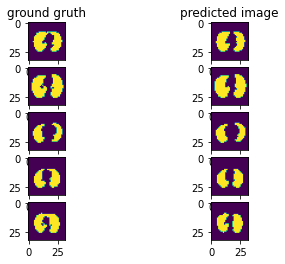

In [ ]:
#using numpy for visualization

_, pic = plt.subplots(5, 2)
count = 0
GT = np.empty((0,1,32 ,32))
OP = np.empty((0,1,32 ,32))
pic[0,0].title.set_text('ground gruth')
pic[0,1].title.set_text('predicted image')

for data in val_dataloader:
    if count>5:
        break
    #data   
    labels = (data['mask'] // 255).to(device)
    images = (data['image'] / 255).to(device)
    outputs = model.forward(images)
    
    GT = np.append(GT, labels.long().cpu().numpy(), axis=0)
    OP = np.append(OP, (outputs>0.5).long().cpu().numpy(), axis=0)
    count+=1



## without gray filter
for i in range(5):
    pic[i, 0].imshow(GT[i][0].squeeze())
    pic[i, 1].imshow(OP[i][0].squeeze())



## Improve U-Net (bonus)

improve U-Net and compare accuracy and networks outputs with previous parts.